# Costumer Segmentation
## In this project we want to extract the number of costumer types, i.e., costumer segmentation by using the KMeans algorithm (unsupervised ML) to cluster the data.


### 1)Import Packages

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler


### 2) Load the data and study the quality

In [2]:
data=pd.read_csv('Mall_Customers.csv')
print(data.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


The number of rows are: 200
The number of columns are: 5
Column names: ['CustomerID' 'Gender' 'Age' 'Annual Income (k$)' 'Spending Score (1-100)']


Inspect the types of each columns
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


Inspect the missing data
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


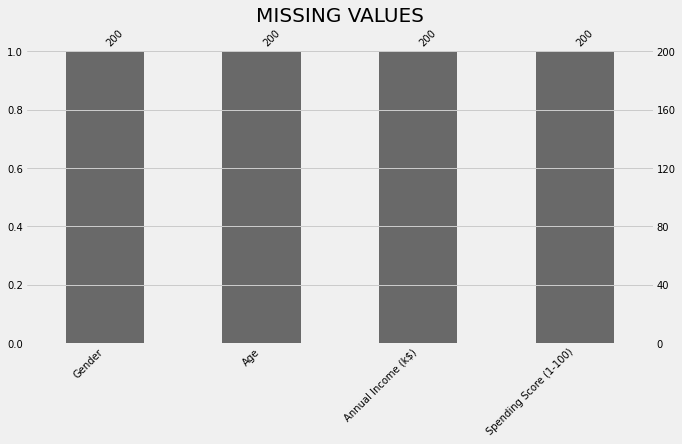

In [3]:
print('The number of rows are:',data.shape[0])
print('The number of columns are:',data.shape[1])
print('Column names:', data.columns.values)
print('\n')
print('Inspect the types of each columns')
print(data.dtypes)
print('\n')
print('Inspect the missing data')
plt.style.use('fivethirtyeight')

#Delete the CustomerID columns because its irrelevant
data.drop(columns='CustomerID',inplace=True)

#plot the missing data to visualize more easily 
print(data.isna().sum())

msno.bar(data,fontsize=10,figsize=(10,5))
plt.title('MISSING VALUES',fontsize=20)
plt.show()

As we can see we dont have any missing values but we need the change the values of the gender column. 

0: Male
1: Female

In [4]:
data['Gender'].replace({'Male':0,'Female':1},inplace=True)
print(data.head())
print('Inspect if the type of the columns corresponds to the new values')
print(data.dtypes)

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       0   19                  15                      39
1       0   21                  15                      81
2       1   20                  16                       6
3       1   23                  16                      77
4       1   31                  17                      40
Inspect if the type of the columns corresponds to the new values
Gender                    int64
Age                       int64
Annual Income (k$)        int64
Spending Score (1-100)    int64
dtype: object


### 3)Univariate Analysis

In [5]:
print(data.describe())

           Gender         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean     0.560000   38.850000           60.560000               50.200000
std      0.497633   13.969007           26.264721               25.823522
min      0.000000   18.000000           15.000000                1.000000
25%      0.000000   28.750000           41.500000               34.750000
50%      1.000000   36.000000           61.500000               50.000000
75%      1.000000   49.000000           78.000000               73.000000
max      1.000000   70.000000          137.000000               99.000000


we're going to visualize each column 

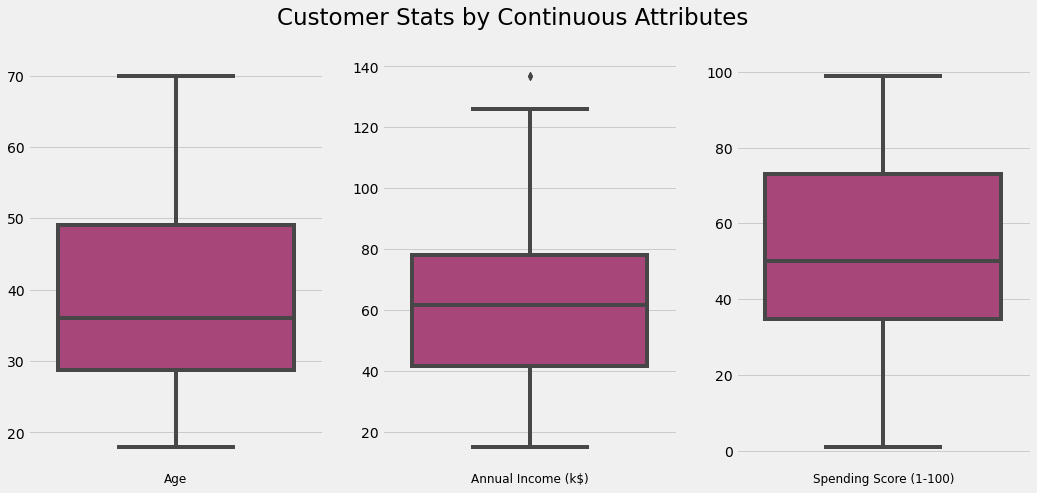

In [6]:
#continuous variables 
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(1, 3, figsize=(16, 7))
fig.suptitle('Customer Stats by Continuous Attributes',fontsize=23)

sns.boxplot(ax=axes[0], data=data ,y='Age',palette='magma')
axes[0].set_ylabel('')
axes[0].set_xlabel('Age',fontsize=12)

sns.boxplot(ax=axes[1], data=data ,y='Annual Income (k$)',palette='magma')
axes[1].set_ylabel('')
axes[1].set_xlabel('Annual Income (k$)',fontsize=12)

sns.boxplot(ax=axes[2], data=data ,y='Spending Score (1-100)',palette='magma')
axes[2].set_ylabel('')
axes[2].set_xlabel('Spending Score (1-100)',fontsize=12)
plt.show()

Age and Annual Income columns have most of the values in the mid-low area wich tells us that these columns dont have a lot of variability and the income column has an outlier

For the Spending Score we have most of the data in the top mid-top area wich tells us that the customers tend to spend more money

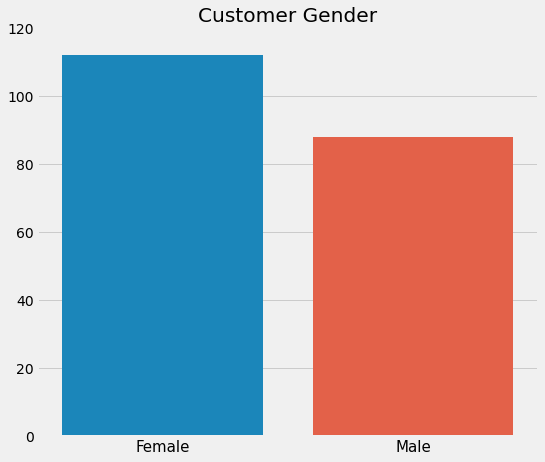

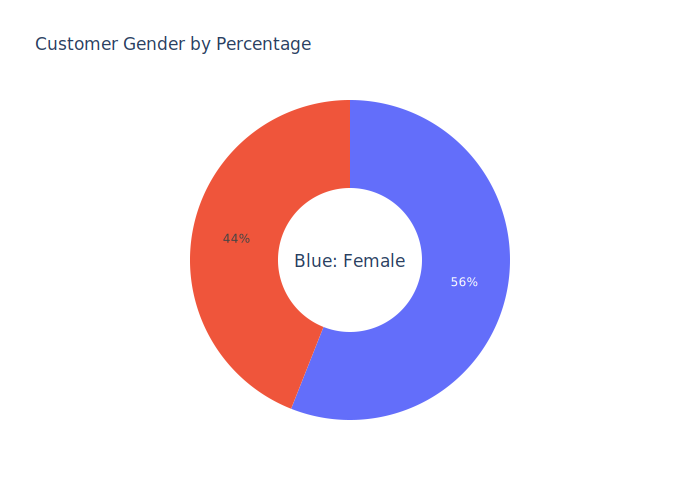

In [7]:
gen=data.Gender.value_counts()

fig, ax1 = plt.subplots(1, 1, figsize=(8, 7))
g=sns.barplot(x=gen.index,y=gen.values,order=[1,0],ax=ax1)
g.set_title('Customer Gender')
g.set_ylim(0,120)
g.set_xticklabels(['Female','Male'],fontsize=15)
plt.show()

g1=px.pie(values=gen.values,names=gen.index,title='Customer Gender by Percentage',hole=0.45,)
g1.update_layout(annotations=[dict(text='Blue: Female', x=0.5, y=0.5, font_size=17, showarrow=False)],                                    showlegend=False)
g1.show('svg')


As we can see most of the data population are females.

*For this analysis we're going to use only continuous variables so we drop gender*

In [8]:
data.drop(columns='Gender',inplace=True)

### 4) bivariate analysis
In this step we are going to analyse the relation between the variables 

In [9]:

cormatrix=data.corr().transpose()
print(' Mall Customers Data Correlation Matrix')
print(cormatrix)

 Mall Customers Data Correlation Matrix
                             Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000


In order to visualize the correlation matrix more easily we use a heatmap

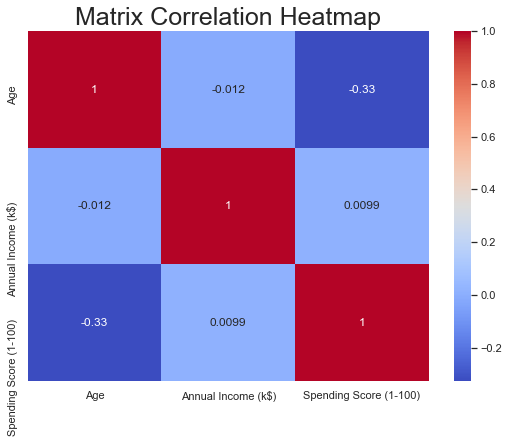

In [10]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(cormatrix, annot=True,linewidths=0,cmap='coolwarm')
plt.title('Matrix Correlation Heatmap',fontsize=25)
plt.show()

As we can see the features have no relevant correlation. The highest is the one between the spending score and age, wich is negative and has a value of 0.3 wich is low

Now we are going to visualize more insights about the feature relations with a PairGrid with a scatter plot for the upper side a kde plot for the lower side and a histogram in the diagonal 

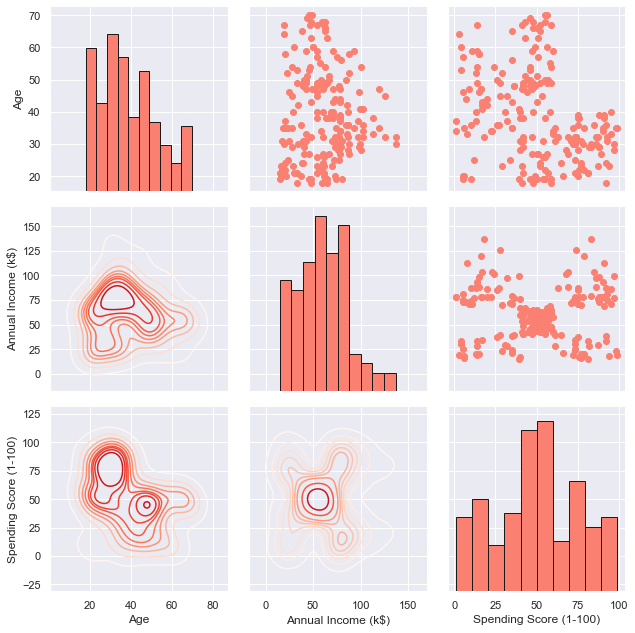

In [11]:
grid = sns.PairGrid(data= data,vars = ['Age', 'Annual Income (k$)','Spending Score (1-100)'], height= 3)

#map functions to the grid
grid = grid.map_upper(plt.scatter, color = 'salmon')
grid = grid.map_diag(plt.hist, bins = 10, color = 'salmon',edgecolor = 'k')
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

Thanks to the PairGrid we are able to understand how the data is distributed 

### 5) Customer Segmentation

In this last step we are going to search for the optimum cluster number using the KMeans algorithm and the elbow method. By the end we will know how much different types of customers we have and what are their consumer qualities. 

In [12]:
scaler=StandardScaler()

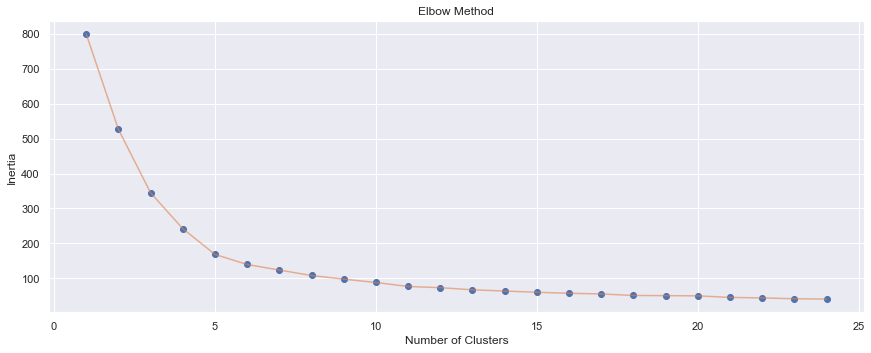

In [44]:
X=data.values
inertia1=[]
for i in range(1,25):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=42)
    X1=scaler.fit_transform(X)
    kmeans.fit(X1)
    inertia1.append(kmeans.inertia_)

plt.figure(1 , figsize = (13 ,5))
plt.plot(np.arange(1 , 25) , inertia1 , 'o')
plt.plot(np.arange(1 , 25) , inertia1 , '-' , alpha = 0.6)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

The elbow method consists in execute the kmeans algorithm for a range of cluster numbers (in this case from 1 to 24) and find the number where the inertia value decreases sharply. The lowest inertia value should not be used because it may cause an overfitting of the model, in other words, if I decided to select the lowest inertia it would imply a large number of clusters and that may lead us to train a model with noise and that will lead to a bad performance.

The Elbow Method plot indicates that the number of clusters may be 5 or 6 because there is where the inertia stops to decrease sharply. I
 will check this by analyzing their silhouette scores.

   n_clusters  average sillhouette score
0           3                   0.423928
1           4                   0.470189
2           5                   0.512232
3           6                   0.501794
4           7                   0.480309


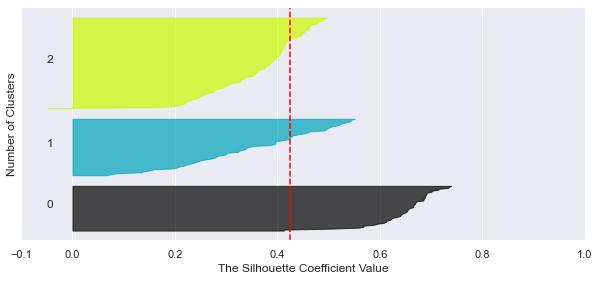

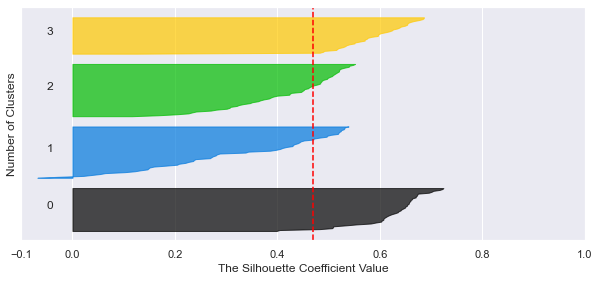

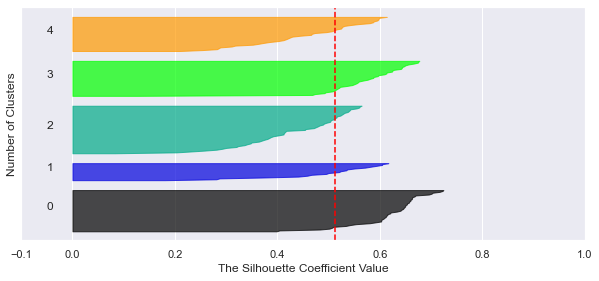

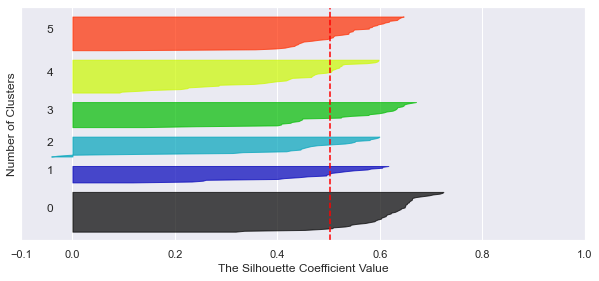

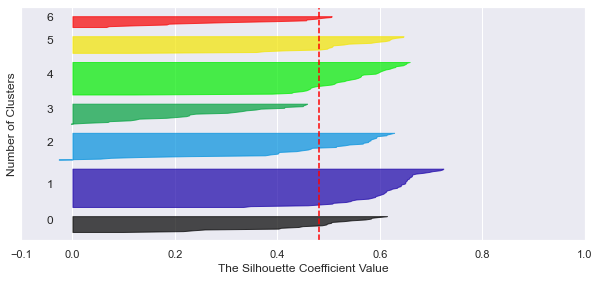

In [45]:
n_clust_lst=[]
avg_sil_score=[]

for n_clusters in range(3,8):
    fig, ax1= plt.subplots()
    fig.set_size_inches(9, 4)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X1) + (n_clusters + 1) * 10]) # blank space between silhouette plots of individual clusters

    kmeans2 = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans2.fit_predict(X1)

    silhouette_avg = silhouette_score(X1, cluster_labels)
    n_clust_lst.append(n_clusters)
    avg_sil_score.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette = silhouette_samples(X1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        #silhouette plot
        i_cluster_silhouette_values = \
            sample_silhouette[cluster_labels == i]

        i_cluster_silhouette_values.sort()

        size_cluster_i = i_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, i_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  

    ax1.set_xlabel('The Silhouette Coefficient Value')
    ax1.set_ylabel('Number of Clusters')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

comparison=pd.DataFrame(data={'n_clusters':n_clust_lst,'average sillhouette score':avg_sil_score})
print(comparison)

As you can see in the comparison 

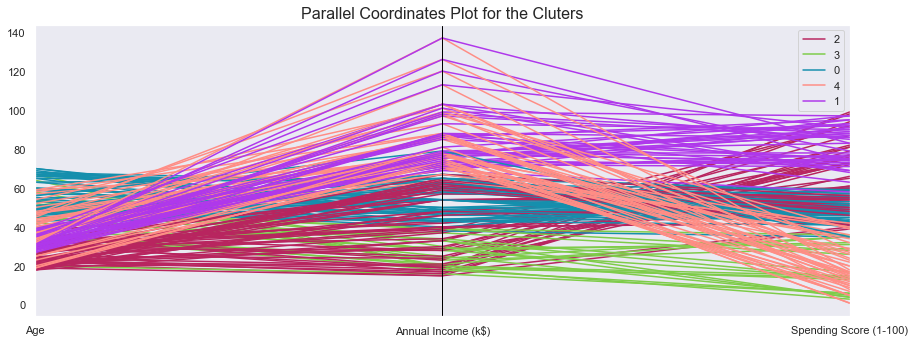

In [38]:
kmeans1 = KMeans(n_clusters= 5, init='k-means++', random_state=42)
kmeans1.fit(X1)
predict = kmeans1.predict(X1)
data['cluster'] = predict

#Plot all the customers and their segmentation
color_codes=('#B8255F','#7ECC49','#158FAD','#FF8D85','#AF38EB')

plt.figure(1 , figsize = (13 ,5))
pd.plotting.parallel_coordinates(data, 'cluster',color=color_codes)
plt.title('Parallel Coordinates Plot for the Cluters',fontsize=16)
plt.show()


As we can see this chart isn't very helpful because its full of information, so in order to visualize the customer segmentation more easily we are going to use the centroids of the clusters

In [16]:
#We deleted the cluster column from the previous step because is making noise 
data.drop(columns=['cluster'],inplace=True)

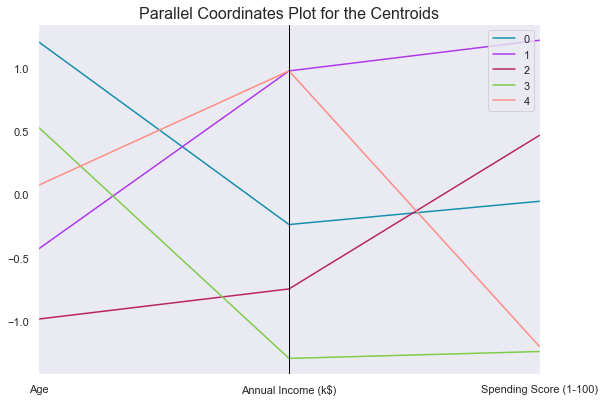

In [17]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans1.cluster_centers_,columns=data.columns)
centroids['cluster'] = centroids.index
color_codes1=('#158FAD','#AF38EB','#B8255F','#7ECC49','#FF8D85')

cent2=pd.plotting.parallel_coordinates(centroids,'cluster',color=color_codes1)
plt.title('Parallel Coordinates Plot for the Centroids',fontsize=16)
plt.show()

The centroids allow us to display the clusters in a very clean and helpful way

# Conclusion

## In order to understand the clusters and  the customers segmentation:

## 0:
* ### The oldest group by age
* ### They doesn't spend so much and they have a regular spending score (aprox 50)

## 1:
* ### This group has people between the ages of 20 and 40 years old.
* ### They have one of the highest annual income and a higher spending socre

## 2:
* ### The youngest group by age
* ### They have a lower annual income and the second highest spending score

## 3:
* ### The second oldest group by age
* ### They have the lowest income and the lowest speding score

## 4: 
* ### This group has a large variation by age 
* ### They have one of the highest annual income and one of the lowest spending score

* # Conclusion y bien redactada
* # Solo usaste la métrica de inercia para optimizar ¿por qué? explica porque esa y no otra de las que existen o ¿qué hubiera pasado si te daba que el número óptimo eran 20? ¿lo seleccionabas igual?
* # metricas tecnicas
    * # Qué tan cercanos quedan los elementos de cada cluster
     * # Qué tan separados están los cluster entre si
